In [1]:
import numpy as np
from scipy.stats import gamma
from scipy.fft import ifft
import sympy as sp 
import matplotlib.pyplot as plt
import pyfeng as pf
from fft import InvLap

In [2]:
# params: page 1688   
# T as 0.5 or 0.25

texp, v0, k, theta, epsilon = 0.5, 0.0348, 1.15, 0.0348, 0.39

d:\Code\Python3.10\lib\site-packages\pyfeng\bsm.py:444: RuntimeWarning: invalid value encountered in log
  log_p_2pi = np.log(p) + MathConsts.M_LN2PI_2  # 0.5*np.log(2*np.pi)


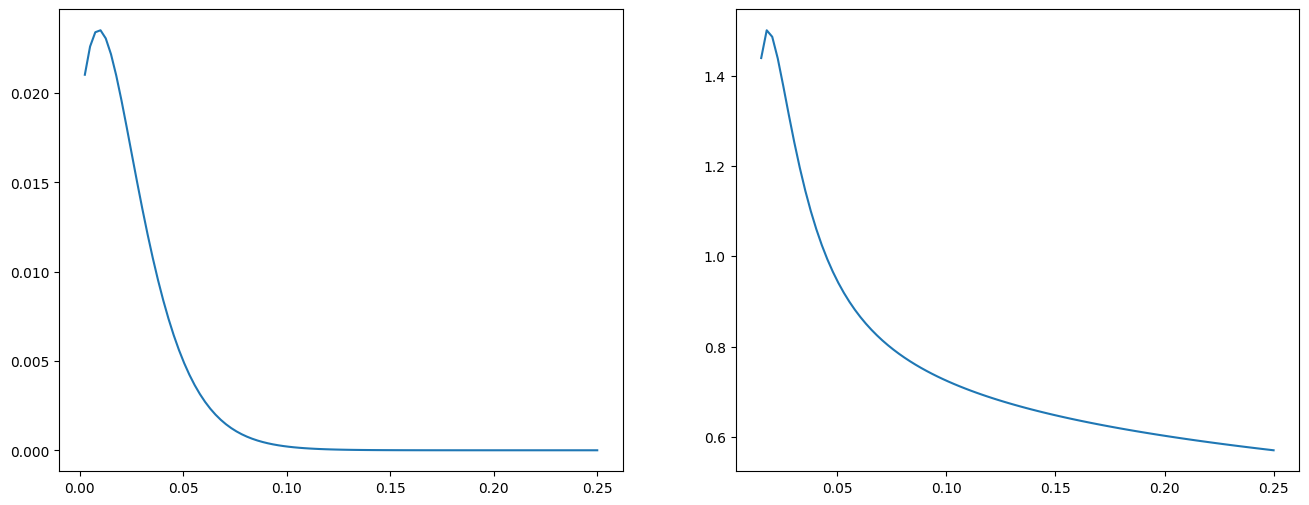

In [4]:
strike = np.linspace(0, 0.25, 100)[1:]
c = cbarheston(0.5)
p = np.array([])
for i in strike:
    p = np.r_[p, c.cbar(i)]

demovol = pf.Bsm(sigma=1)   # initialize a Bsm
impvol = demovol.impvol(p, strike, v0, 0.5)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(strike, p)
ax[1].plot(strike[5:], impvol[5:])

In [5]:
def gammacdf(t, alpha, beta):
    x = sp.symbols('x')
    return sp.integrate((1/(sp.gamma(alpha) * beta**alpha)) * x**(alpha - 1) * sp.exp(-x/beta), (x, 0, t))

class cbarhestonsp():

    def __init__(self, texp, k, v0, theta) -> None:
        self.k, self.v0, self.theta, self.texp = k, v0, theta, texp

    def c0(self):
        eq1 = self.v0 / self.k * (1 - sp.exp(-self.k * self.texp))
        eq2 = self.theta / self.k * (sp.exp(-self.texp) - 1)
        eq3 = self.theta * self.texp
        return eq1 + eq2 + eq3
    
    def beta(self, sigma=1):
        return self.c0() * (sp.exp(sigma ** 2 * self.texp) - 1)
    
    def alpha(self):
        return self.c0() / self.beta()

    def cbar(self, strike):
        alpha, beta = self.alpha(), self.beta()
        res = (
            alpha * beta * (1 - gammacdf(strike, alpha + 1, beta))      # could only accept single strike, array not allowed
            + strike * (1 - gammacdf(strike, alpha, beta))        
        )
        return res

In [6]:
class laplace(cbarhestonsp):

    def trans(self):
        strike, lbd = sp.symbols('k l')
        F, _, _ = sp.laplace_transform(self.cbar(strike), strike, lbd)
        return F

In [7]:
laplace(texp=texp, k=k, v0=v0, theta=theta).trans()

-0.0136760331846708*LaplaceTransform(lowergamma(2.5414940825368, 82.3174773312411*k), k, l) - Derivative(-1.12577655166044*LaplaceTransform(lowergamma(1.5414940825368, 82.3174773312411*k), k, l) + 1/l, l) + 0.0187262065421892/l

In [8]:
a, b = sp.symbols('a b')
res, _, _ = sp.laplace_transform(gammacdf(a, .5, .5), a, b)
res

0.564189583547756*LaplaceTransform(lowergamma(0.5, 2.0*a), a, b)

In [9]:
x = sp.symbols('x')
sp.lowergamma(3, x)

-2*(x**2/2 + x + 1)*exp(-x) + 2

In [10]:
def L_C0_heston(λ, k=k, θ=theta, ε=epsilon, T=texp, v0=v0):
    λ /= T
    γ = np.sqrt(k**2 + 2*λ*ε**2)
    b_0T = 2*λ*(np.exp(γ*T)-1)/((γ+k)*(np.exp(γ*T)-1) + 2*γ)
    α = γ + k
    β = γ - k

    a_0T = (k*θ/ε**2) * (k-γ)*T

    dt = 1e-3
    n_dt = int(T / dt)
    t = np.arange(0, T, dt)
    for k in range(n_dt-1):
        part1 = α*np.exp(γ*(T-t[k+1]))
        part2 = β*np.exp(-γ*dt)
        a_0T -= (2*k*θ/ε**2) * np.log((part1+part2) / (part1+β))

    L = np.exp(a_0T - b_0T*v0)
    return L

def L_heston(l):
    return (L_C0_heston(l) - 1)/l**2 + cbarheston(texp=texp).c0()/l

C:\Users\shenm\AppData\Local\Temp\ipykernel_19376\4271724804.py:3: RuntimeWarning: invalid value encountered in sqrt
  γ = np.sqrt(k**2 + 2*λ*ε**2)
C:\Users\shenm\AppData\Local\Temp\ipykernel_19376\4271724804.py:22: RuntimeWarning: invalid value encountered in divide
  return (L_C0_heston(l) - 1)/l**2 + cbarheston(texp=texp).c0()/l
C:\Users\shenm\AppData\Local\Temp\ipykernel_19376\4271724804.py:22: RuntimeWarning: divide by zero encountered in divide
  return (L_C0_heston(l) - 1)/l**2 + cbarheston(texp=texp).c0()/l


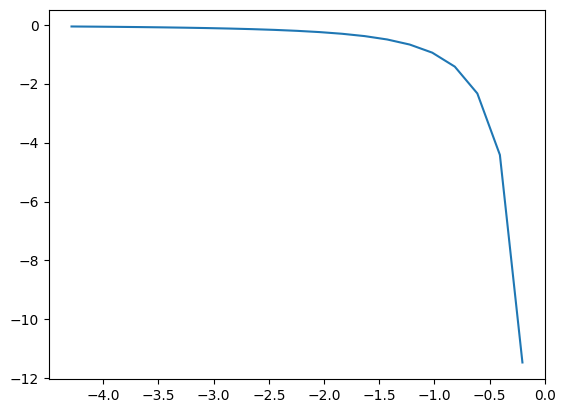

In [11]:
x = np.linspace(-5, 0, 50)
y = L_heston(x)
plt.plot(x, y)

In [12]:
from laplace_variance import wang, shen
import numpy as np
import matplotlib.pyplot as plt


In [13]:
n, dt = 100_000, 1e-2
path, c0 = wang.C0_simulation_heston(wang.variance_heston(v0, k, theta, epsilon, 0), n, dt, texp)

f:\Code\Github\PHBS_ASP_2023\Project\pre0419\laplace_variance\wang.py:31: RuntimeWarning: invalid value encountered in sqrt
  dvt = k_H * (θ_H - vt[-1]) * dt + ε_H * np.sqrt(vt[-1]) * Z[time, _] * np.sqrt(dt)


In [16]:
v_heston = wang.variance_heston(v0, k, theta, epsilon, 0)

In [125]:
#------------------------------------------------------------
def invlt(t, fs, sigma, omiga, nint):
    omigadim = np.linspace(0, omiga, nint+1, endpoint=True)
    y = [(np.exp(1j*o*t) * fs(sigma+1j*o)).real for o in omigadim]
    y_left = y[:-1]
    y_right = y[0:]
    T = sum(y_right + y_left) * omiga/nint
    return np.exp(sigma*t) * T/ np.pi / 2

#------------------------------------------------------------
def fs(s):
    return 1/(s+1)

#------------------------------------------------------------
sigma = 100
omiga = 10
nint=omiga*50

tdim = np.linspace(0, .25, 200)
ft = [invlt(t, f_heston, sigma, omiga, nint) for t in tdim]

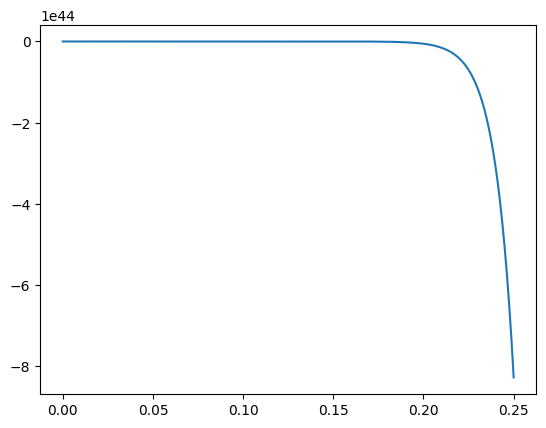

In [126]:
plt.plot(tdim, ft)

In [50]:
f_heston = lambda x: wang.direct_Lk(x, c.c0(), 'Heston', v_heston, texp)

f:\Code\Github\PHBS_ASP_2023\Project\pre0419\laplace_variance\wang.py:194: RuntimeWarning: invalid value encountered in scalar divide
  L = (math_L-1)/λ**2 + C0/λ
f:\Code\Github\PHBS_ASP_2023\Project\pre0419\laplace_variance\wang.py:194: RuntimeWarning: divide by zero encountered in scalar divide
  L = (math_L-1)/λ**2 + C0/λ


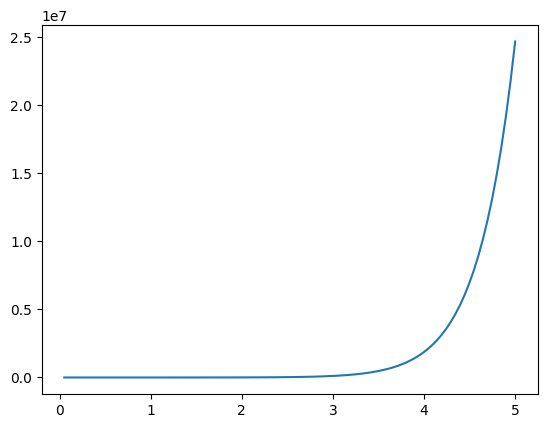

In [124]:
var_strikes = np.linspace(0, 5, 100)
plt.plot(var_strikes, [f_heston(f) for f in var_strikes])

In [128]:
wang.parameters_inv()

(32,
 256,
 0.171875,
 16,
 array([ 4.44090000e-16,  6.28320000e+00,  1.25664000e+01,  1.88503000e+01,
         2.52872000e+01,  3.42970000e+01,  5.61726000e+01,  1.70533100e+02,
        -1.76816285e+02, -6.24557853e+01, -4.05801853e+01, -3.15703853e+01,
        -2.51334853e+01, -1.88495853e+01, -1.25663853e+01, -6.28318531e+00]),
 array([ 1.    ,  1.    ,  1.    ,  1.0008,  1.0958,  2.0069,  5.9428,
        54.9537, 54.9537,  5.9428,  2.0069,  1.0958,  1.0008,  1.    ,
         1.    ,  1.    ]))

In [218]:
import importlib
importlib.reload(shen)
importlib.reload(wang)

<module 'laplace_variance.wang' from 'f:\\Code\\Github\\PHBS_ASP_2023\\Project\\pre0419\\laplace_variance\\wang.py'>

In [211]:
shen.upper_l(.2, c.c0(), v_heston, texp)

0.0662018573255374

In [232]:
params = wang.parameters_inv(times = 5)
g_hat = lambda x: shen.upper_l(x, c.c0(), v_heston, texp)
price = [shen.inv_lap(k, params, g_hat) for k in np.linspace(1e-2, .5, 50)]
price

[(0.008032810537380865+0.00024277857594034186j),
 (0.007782761154571708+0.000470238019062223j),
 (0.007520275937842297+0.0006816422795256353j),
 (0.007246288345200443+0.0008762725636896426j),
 (0.006961774144180473+0.0010534639359082332j),
 (0.006667748292648658+0.0012126078348680001j),
 (0.006365261668948653+0.0013531544082804679j),
 (0.006055397662021959+0.0014746146568666147j),
 (0.0057392686326850845+0.0015765623791961579j),
 (0.005418012257755771+0.0016586359096036748j),
 (0.005092787769191156+0.0017205396420926465j),
 (0.004764772100831568+0.0017620453338572698j),
 (0.004435155955730758+0.0017829931827961529j),
 (0.004105139807397499+0.001783292674160183j),
 (0.003775929848570749+0.0017629231922659271j),
 (0.003448733901401847+0.0017219343940134372j),
 (0.003124757303120133+0.0016604463417701208j),
 (0.0028051987814120428+0.0015786493940180173j),
 (0.00249124633384801+0.001476803853006963j),
 (0.0021840731257452986+0.0013552393695080074j),
 (0.0018848334208575207+0.00121435410561

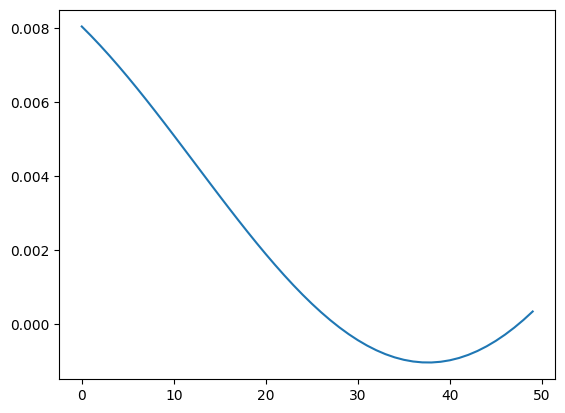

In [233]:
plt.plot( np.array(price).real)

In [226]:
params = wang.parameters_inv(times = 5)
g_hat = lambda x: shen.upper_l(x, c.c0(), v_heston, texp) - c.Laplace_transform(x)
price = wang.inv_algo_ghat(params, g_hat)

In [227]:
price

[(-8.895411962583921e-09-1.944222560723574e-12j),
 (0.16472753844492333-2.319368797195461e-12j),
 (1.3264762689207457-2.75243979763684e-12j),
 (4.487303221830024-3.293889256063394e-12j),
 (10.6499004879637-3.897459445519515e-12j),
 (20.817447201623317-4.639359993525573e-12j),
 (35.99352226549027-5.538645065777702e-12j),
 (57.18204315937753-6.469333624935085e-12j),
 (85.38721931070972-7.693940411336793e-12j),
 (121.61351472059374-9.173281541656064e-12j),
 (166.8656169733244-1.0848956613867297e-11j),
 (222.14841090603016-1.3577631765285906e-11j),
 (288.46695582656145-1.5350130035663247e-11j),
 (366.8264655221474-1.7110823322826508e-11j),
 (458.2322905203407-2.099692564109545e-11j),
 (563.6899022062225-2.7300681174353525e-11j),
 (684.2048784962591-2.956178412423805e-11j),
 (820.7828908367487-3.348034779041571e-11j),
 (974.4296923434648-4.2065960977795155e-11j),
 (1146.151106935067-5.462544444174677e-11j),
 (1336.9530193399153-5.874918212444679e-11j),
 (1547.8413658767602-6.734239817704106